In [11]:
import matplotlib
#matplotlib.use('Agg')
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

# Para manejar los archivos y automatizar la lectura en directorios
import csv
import os
# Fontsize
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
# Latex font
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Nombres de archivo, paths y definiciones
La informacion de redshift solo se encuentra en los halos lvl3 dado que se necesita mucha resolucion a alto redshift donde el halo es mas pequeno

In [24]:
# SOME DEFINITIONS
# The directory where information lies
direc = '../Data/Halo_Detail/'
# Level of the simulation 
lvl = 'level3_'
# If DM or MHD
sim_det = 'DM'

# la carpeta completa
lvl = lvl+sim_det

# Halos de la simulacion de nivel 3
#halos = [6,16,21,23,24,27]
halos = [24]

# Data format
El formato de la data se explica con la siguiente funcion

In [33]:
# En esta funcion se obtiene la data de un halo dadas sus especificaciones
# Parametros necesarios:
# directorio - el directorio donde se encuentran los datos
# level      - el nivel de la simulacion incluyendo si es DM o MHD
# halo       - el numero del halo
# Retorna:
# Una lista de arrays con el radial profile y su respectivo redshift
def get_data(directorio,level,halo):
    # El path en donde esta la informacion
    path = directorio+level+'/halo_'+str(halo)
    
    # List of directories
    # Cada radial profile esta en una carpeta diferente para redshift diferentes
    # Se obtienen las carpetas de los redshifts
    listdir = next(os.walk(path))[1]
    if 'rand_sample' in listdir:
        listdir.remove('rand_sample')
    # Retorna el numero del snapshot para ordenar
    def getkey(l):
        return int(l.split("_")[1])
    # ordena por numero de snapshot
    listdir.sort(key=getkey)
    #print(listdir)
    
    # La lista en la que se van a guardar los radial profiles
    list_radial_profiles = []
    # Obtiene la informacion para cada subdirectorio
    for sub_dir in listdir:
        # Loads information dictionary
        # Esta informacion es cargada en info.npy como un objeto de numpy
        # y se carga de la siguiente manera
        info = np.load(path+"/"+sub_dir+"/info.npy",encoding = 'latin1')
        # Por ahora solo queremos el redshift\
        # Pero contiene informacion del scale factor y los radios R_DM,R_BH y R_Star
        redshift = info.item().get('Redshift')
        #print("Redshift: "+str(redshift))
        
        #if redshift > 2:        
        # Semiaxes
        # Se cargan los semiejes en formato a,b,c 
        # el radio de sampleo es la media geometrica de abc
        arr = np.loadtxt(path+"/"+sub_dir+"/s"+sub_dir.split("_")[1]+".txt", delimiter = ",")

        # anade la informacion

        list_radial_profiles.append([redshift,arr])
    
    return list_radial_profiles
    

# Usage
A continuacion un ejemplo de como se usa la funcion definida anteriormente, en este caso para el ejercicio de triaxialidad

In [36]:
# The geometric mean
from scipy.stats.mstats import gmean
# Fonts 
MEDIUM_SIZE = 30
SMALL_SIZE = 25
SSSMALL_SIZE = 17
plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

#halonums = [24]
with PdfPages("../Graphs/Redshift_"+lvl+".pdf") as pdf:
    for halo in halos:
        print(halo)

        # Load the ddata
        data_halo = get_data(direc,lvl,halo)
        #print(data_halo)

        # Plots    
        ylabel = ['b/a','c/a','T']
        fig, axs = plt.subplots(figsize=(10,15),nrows=3)

        # Color settings for redshift
        my_norm = colors.Normalize(0.0,0.4)
        mapa = cm.ScalarMappable(norm=my_norm, cmap="CMRmap")

        for redshift,axes in data_halo:
            print(redshift)
            # Axial ratios and radii (including rvir)
            # Cuidado con la dimension del array
            if axes.ndim > 1:
                a,b,c = axes[:-1].T
            else: 
                a,b,c = axes
            xvals = (a*b*c)**(1./3.)
            # Cantidades a plotear
            yvals = np.array([b/a,c/a,(a**2-b**2)/(a**2-c**2)])
            
            #print(yvals)
            # Virial rad
            rvir = 0
            # Cuidado con la dimension de los semiejes
            # a veces se tiene baja resolucion y es solo un datao para ejes
            if axes.ndim == 1:
                rvir = gmean(axes)
            else:
                rvir = gmean(axes[-1])

            mappable = 0
            # Hace la grafica para cada eje
            for ax,yval,ylab in zip(axs,yvals,ylabel):
                
                # Define el color para el redshift
                my_col = mapa.to_rgba(1.-(1.0/(1.0+redshift)))
                
                # para tener solo un label 
                if(redshift < 1e-6):
                    mappable = ax.plot(xvals,yval, color = my_col, linewidth=1, label = "Radial shape", alpha = 1,zorder=10)
                    ax.plot([rvir,rvir],[0,0.5], color = my_col, linestyle = '-.',label = r"$R_{500}$",zorder =1)
                else:
                    mappable = ax.plot(xvals,yval, color = my_col, linewidth=0.5,  alpha = 1,zorder = 10)
                    ax.plot([rvir,rvir],[0,0.5], color = my_col,linestyle = '-.',zorder=1)

                # Major ticks every 20, minor ticks every 5
                major_ticksy = np.linspace(0, 1, 3)
                minor_ticksy = np.linspace(0, 1, 11)
                major_ticksx = np.logspace(-1, 2, 3)
                minor_ticksx = np.logspace(-1, 2, 30)

                ax.set_xticks(major_ticksx)
                ax.set_xticks(minor_ticksx, minor=True)
                ax.set_yticks(major_ticksy)
                ax.set_yticks(minor_ticksy, minor=True)
                ax.grid(which='both')
                ax.grid(which='minor', alpha=0.3)
                ax.grid(which='major', alpha=0.6)
                
                # Log scale for radius
                ax.set_xscale('log')
                ax.set_ylabel(ylab)

                # Plotting ratios
                ax.set_ylim(0,1)

                # Axs specs
                ax.set_xlim(3,rvir+30)
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

                # Hide axes 
                plt.setp( ax.get_xticklabels(), visible=False)                


        # Axs specs  
        #axs[0].legend(loc='upper left', bbox_to_anchor=(1, 0.5))  

        xticks = [0, 0.5, 1, 2]
        yticks = [1.- 1.0/(1.0+x) for x in xticks]

        # Colorbar ax
        cbaxes = fig.add_axes([0.95, 0.1, 0.02, 0.8]) 
        cbar = mpl.colorbar.ColorbarBase(cbaxes, cmap = "CMRmap", norm = my_norm, orientation = 'vertical', ticks = yticks )  
        cbar.ax.set_yticklabels(xticks)
        cbar.set_label('$Redshift$', fontsize=30 )

        axs[-1].legend(loc = 0)
        axs[-1].set_xlabel("R(Kpc/h)")
        plt.setp( axs[-1].get_xticklabels(), visible=True)                
        #axs[0].set_title(halo+"  Rvir="+str(rvir)+"Kpc" )  
        #axs[0].set_title(halo)  

        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

24
0.460917794181
0.419968941997
0.38016786726
0.347853841858
0.310074120128
0.273353346578
0.243540181555
0.214425035514
0.180385261706
0.152748768902
0.125759332411
0.0994018026302
0.0736613846564
0.0485236299818
0.0239744283828
2.22044604925e-16


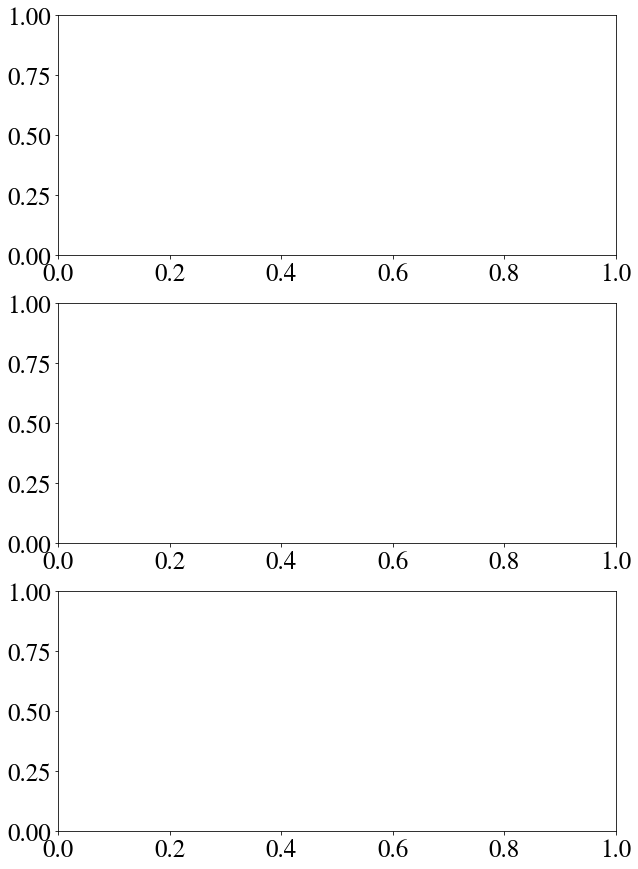

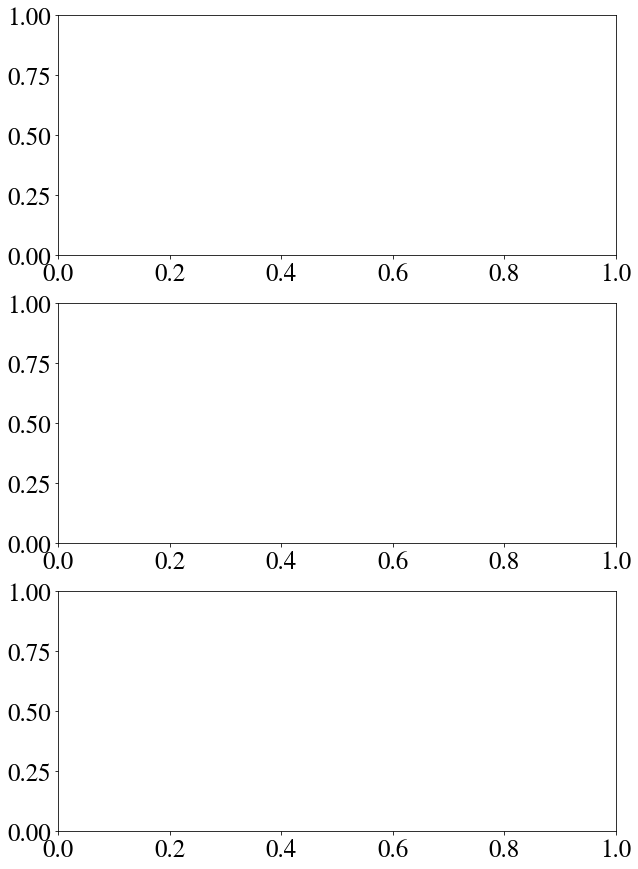

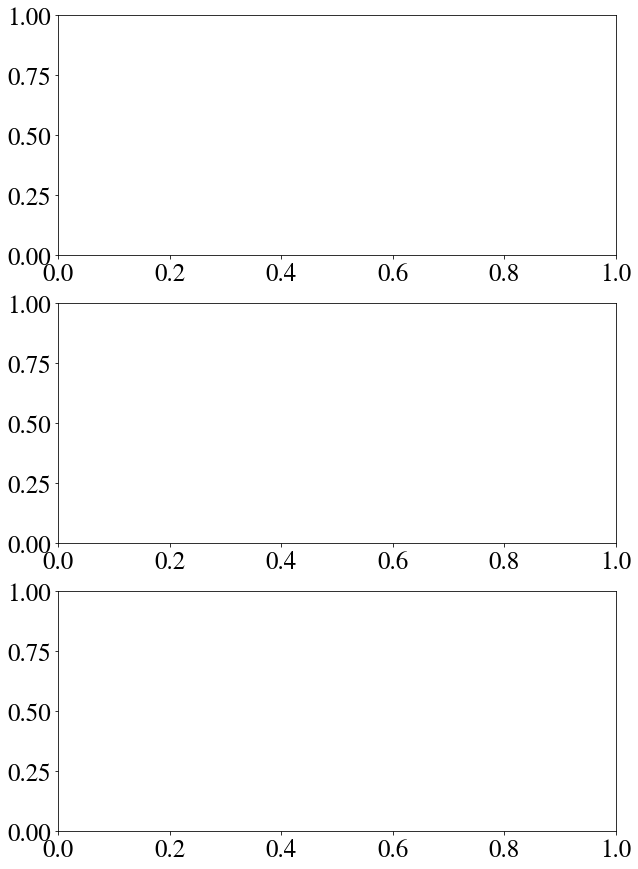

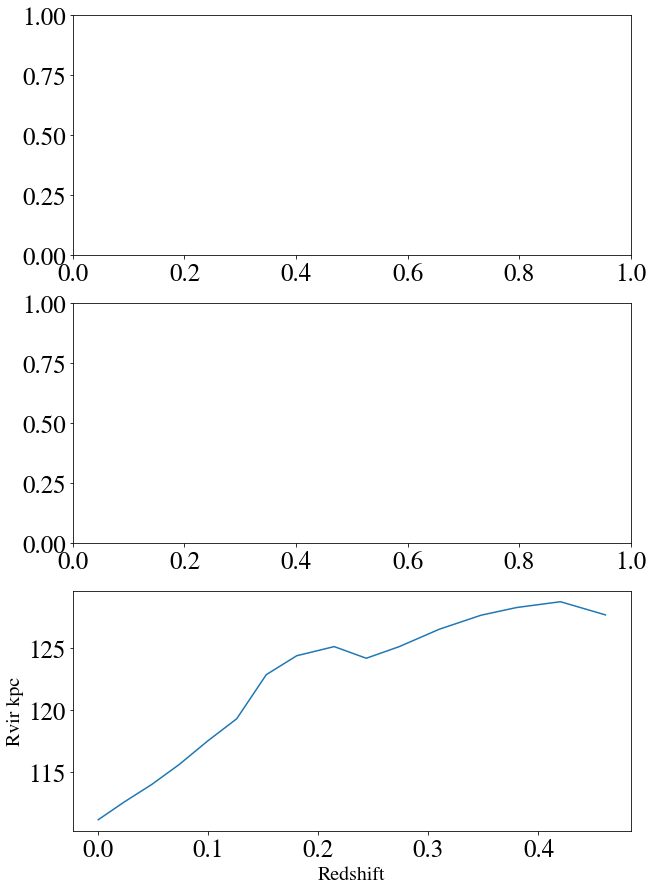

In [37]:
# The geometric mean
from scipy.stats.mstats import gmean

# El primer Halo
specific_halo = halos[0]
# Tomamos los datos
data_halo = get_data(direc,lvl,specific_halo)
# Vamos a plotear el radio virial (ultimo radio sampleado), en funcion del redshift
redshift = []
vir_rad = []
for red,axes in data_halo:
    redshift.append(red)
    rvir = 0
    # Cuidado con la dimension de los semiejes
    # a veces se tiene baja resolucion y es solo un datao para ejes
    if axes.ndim == 1:
        rvir = gmean(axes)
    else:
        rvir = gmean(axes[-1])
    vir_rad.append(rvir)
    
redshift = np.array(redshift)  
vir_rad = np.array(vir_rad)
indices = np.argsort(redshift)
plt.plot(redshift[indices],vir_rad[indices])
plt.xlabel('Redshift',fontsize =20)
plt.ylabel('Rvir kpc',fontsize =20)
plt.show()

In [38]:
data_halo

[[0.46091779418064749, array([[   5.85196338,    2.5066939 ,    2.0310823 ],
         [   6.41507469,    2.7552388 ,    2.21972061],
         [   7.03904331,    3.02943624,    2.42520927],
         [   7.72096752,    3.33378443,    2.64619487],
         [   8.47617236,    3.68503073,    2.90160914],
         [   9.2685593 ,    4.05587669,    3.168721  ],
         [  10.14902444,    4.46613457,    3.46186024],
         [  11.11805613,    4.92179275,    3.77932939],
         [  12.18670908,    5.43507891,    4.13662185],
         [  13.34731127,    5.99201026,    4.51484679],
         [  14.61767685,    6.64528548,    4.93357197],
         [  15.97436812,    7.39406511,    5.43785159],
         [  17.38148084,    8.22582204,    6.02570243],
         [  18.82899126,    9.12812169,    6.6963044 ],
         [  19.54245212,    9.57230492,    7.04938852],
         [  21.40981951,   10.70523809,    7.95600963],
         [  23.45424694,   11.92135647,    8.9326773 ],
         [  25.65028302,   